# How we solve a model defined by the `IndShockConsumerType` class
The IndShockConsumerType reprents the work-horse consumption savings model with temporary and permanent shocks to income, finite or infinite horizons, CRRA utility and more. In this DemARK we take you through the steps involved in solving one period of such a model. The inheritance chains can be a little long, so figuring out where all the parameters and methods come from can be a bit confusing. Hence this map! The intention is to make it easier to know how to inheret from IndShockConsumerType in the sense that you know where to look for specific solver logic, but also so you know can figure out which methods to overwrite or supplement in your own `AgentType` and solver!
## The `solveConsIndShock` function
In HARK, a period's problem is always solved by the callable (function or callable object instance) stored in the field `solve_one_period`. In the case of `IndShockConsumerType`, this function is called `solveConsIndShock`. The function accepts a number of arguments, that it uses to construct an instance of either a `ConsIndShockSolverBasic` or a `ConsIndShockSolver`. These solvers both have the methods `prepare_to_solve` and `solve`, that we will have a closer look at in this notebook. This means, that the logic of `solveConsIndShock` is basically:

 1. Check if cubic interpolation (`CubicBool`) or construction of the value function interpolant (`vFuncBool`) are requested. Construct an instance of `ConsIndShockSolverBasic` if neither are requested, else construct a `ConsIndShockSolver`. Call this `solver`.
 1. Call `solver.prepare_to_solve()`
 1. Call `solver.solve()` and return the output as the current solution.

### Two types of solvers
As mentioned above, `solve_one_period` will construct an instance of the class `ConsIndShockSolverBasic`or `ConsIndShockSolver`. The main difference is whether it uses cubic interpolation or if it explicitly constructs a value function approximation. The choice and construction of a solver instance is bullet 1) from above.

#### What happens in upon construction
Neither of the two solvers have their own `__init__`. `ConsIndShockSolver` inherits from `ConsIndShockSolverBasic` that in turn inherits from `ConsIndShockSetup`. `ConsIndShockSetup` inherits from `ConsPerfForesightSolver`, which itself is just an `Object`, so we get the inheritance structure

- `ConsPerfForesightSolver` $\leftarrow$ `ConsIndShockSetup` $\leftarrow$ `ConsIndShockSolverBasic` $\leftarrow$ `ConsIndShockSolver`

When one of the two classes in the end of the inheritance chain is called, it will call `ConsIndShockSetup.__init__(args...)`. This takes a whole list of fixed inputs that then gets assigned to the object through a
```
ConsIndShockSetup.assign_parameters(solution_next,IncomeDstn,LivPrb,DiscFac,CRRA,Rfree,PermGroFac,BoroCnstArt,aXtraGrid,vFuncBool,CubicBool)
```
call, that then calls
```
ConsPerfForesightSolver.assign_parameters(self,solution_next,DiscFac,LivPrb,CRRA,Rfree,PermGroFac)
```
We're getting kind of detailed here, but it is simply to help us understand the inheritance structure. The methods are quite straight forward, and simply assign the list of variables to self. The ones that do not get assigned by the `ConsPerfForesightSolver` method gets assign by the `ConsIndShockSetup` method instead.


After all the input parameters are set, we update the utility function definitions. Remember, that we restrict ourselves to CRRA utility functions, and these are parameterized with the scalar we call `CRRA` in HARK. We use the two-argument CRRA utility (and derivatives, inverses, etc) from `HARK.utilities`, so we need to create a `lambda` (an anonymous function) according to the fixed `CRRA` we have chosen. This gets done through a call to

```
ConsIndShockSetup.defUtilityFuncs()
```
that itself calls
```
ConsPerfForesightSolver.defUtilityFuncs()
```
Again, we wish to emphasize the inheritance structure. The method in `ConsPerfForesightSolver` defines the most basic utility functions (utility, its marginal and its marginal marginal), and `ConsIndShockSolver` adds additional functions (marginal of inverse, inverse of marginal, marginal of inverse of marginal, and optionally inverse if `vFuncBool` is true).

To sum up, the `__init__` method lives in `ConsIndShockSetup`, calls `assign_parameters` and `defUtilityFuncs` from `ConsPerfForesightSolver` and defines its own methods with the same names that adds some methods used to solve the `IndShockConsumerType` using EGM. The main things controlled by the end-user are whether cubic interpolation should be used, `CubicBool`, and if the value function should be explicitly formed, `vFuncBool`.
### Prepare to solve
We are now in bullet 2) from the list above. The `prepare_to_solve` method is all about grabbing relevant information from next period's solution, calculating some limiting solutions. It comes from `ConsIndShockSetup` and calls two methods:

1. `ConsIndShockSetup.setAndUpdateValues(self.solution_next,self.IncomeDstn,self.LivPrb,self.DiscFac)`
2. `ConsIndShockSetup.defBoroCnst(self.BoroCnstArt)`

First, we have `setAndUpdateValues`. The main purpose is to grab the relevant vectors that represent the shock distributions, the effective discount factor, and value function (marginal, level, marginal marginal depending on the options). It also calculates some limiting marginal propensities to consume and human wealth levels. Second, we have `defBoroCnst`. As the name indicates, it calculates the natural borrowing constraint, handles artificial borrowing constraints, and defines the consumption function where the constraint binds (`cFuncNowCnst`).

To sum, `prepare_to_solve` sets up the stochastic environment an borrowing constraints the consumer might face. It also grabs interpolants from "next period"'s solution.

### Solve it!
The last method `solveConsIndShock` will call from the `solver` is `solve`. This method essentially has four steps:
 1. Pre-processing for EGM: solver.prepare_to_calc_EndOfPrdvP
 1. First step of EGM: solver.calc_EndOfPrdvP
 1. Second step of EGM: solver.make_basic_solution
 1. Add MPC and human wealth: solver.add_MPC_and_human_wealth

#### Pre-processing for EGM `prepare_to_calc_EndOfPrdvP`
Find relevant values of end-of-period asset values (according to `aXtraGrid` and natural borrowing constraint) and next period values implied by current period end-of-period assets and stochastic elements. The method stores the following in `self`:

 1. values of permanent shocks in `PermShkVals_temp`
 1. shock probabilities in `ShkPrbs_temp`
 1. next period resources in `mNrmNext`
 1. current grid of end-of-period assets in `aNrmNow`

The method also returns `aNrmNow`. The definition is in `ConsIndShockSolverBasic` and is not overwritten in `ConsIndShockSolver`.

#### First step of EGM `calc_EndOfPrdvP`
Find the marginal value of having  some level of end-of-period assets today. End-of-period assets as well as stochastics imply next-period resources at the beginning of the period, calculated above. Return the result as `EndOfPrdvP`.

#### Second step of EGM `make_basic_solution`
Apply inverse marginal utility function to nodes from about to find (m, c) pairs for the new consumption function in `get_points_for_interpolation` and create the interpolants in `use_points_for_interpolation`. The latter constructs the `ConsumerSolution` that contains the current consumption function `cFunc`, the current marginal value function `vPfunc`, and the smallest possible resource level `mNrmMinNow`.

#### Add MPC and human wealth `add_MPC_and_human_wealth`
Add values calculated in `defBoroCnst` now that we have a solution object to put them in.

#### Special to the non-Basic solver
We are now done, but in the `ConsIndShockSolver` (non-`Basic`!) solver there are a few extra steps. We add steady state m, and depending on the values of `vFuncBool` and `CubicBool` we also add the value function and the marginal marginal value function.

## Let's try it in action!
First, we define a standard lifecycle model, solve it and then

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    init_lifecycle,
)
import numpy as np
import matplotlib.pyplot as plt

LifecycleExample = IndShockConsumerType(**init_lifecycle)
LifecycleExample.cycles = (
    1  # Make this consumer live a sequence of periods exactly once
)
LifecycleExample.solve()

Let's have a look at the solution in time period second period. We should then be able to

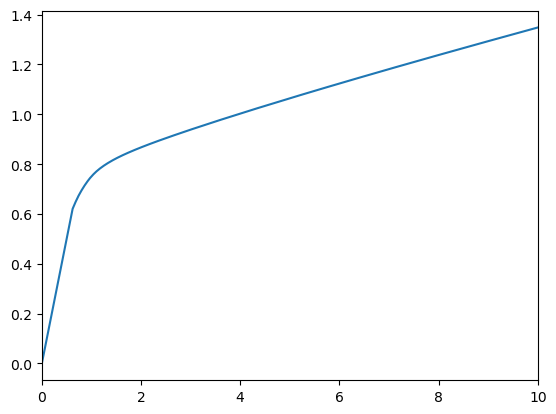

In [2]:
from HARK.utilities import plot_funcs

plot_funcs(
    [LifecycleExample.solution[0].cFunc], LifecycleExample.solution[0].mNrmMin, 10
)

Let us then create a solver for the first period.

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import ConsIndShockSolverBasic

solver = ConsIndShockSolverBasic(
    LifecycleExample.solution[1],
    LifecycleExample.IncShkDstn[0],
    LifecycleExample.LivPrb[0],
    LifecycleExample.DiscFac,
    LifecycleExample.CRRA,
    LifecycleExample.Rfree,
    LifecycleExample.PermGroFac[0],
    LifecycleExample.BoroCnstArt,
    LifecycleExample.aXtraGrid,
    LifecycleExample.vFuncBool,
    LifecycleExample.CubicBool,
)

In [4]:
solver.prepare_to_solve()

Many important values are now calculated and stored in solver, such as the effective discount factor, the smallest permanent income shock, and more.

In [5]:
solver.DiscFacEff

0.9586233599999999

In [6]:
solver.PermShkMinNext

0.6554858756904405

These values were calculated in `setAndUpdateValues`. In `defBoroCnst` that was also called, several things were calculated, for example the consumption function defined by the borrowing constraint.

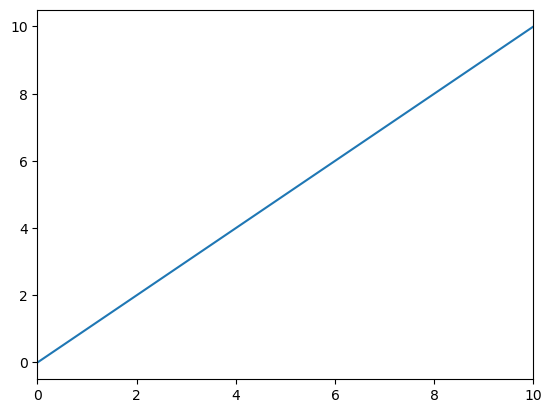

In [7]:
plot_funcs([solver.cFuncNowCnst], solver.mNrmMinNow, 10)

Then, we set up all the grids, grabs the discrete shock distributions, and state grids in `prepare_to_calc_EndOfPrdvP`.

In [8]:
solver.prepare_to_calc_EndOfPrdvP()

array([-1.97928710e-01, -1.78757337e-01, -1.58464113e-01, -1.36959776e-01,
       -1.14146021e-01, -8.99143874e-02, -6.41449810e-02, -3.67050128e-02,
       -7.44711582e-03,  2.37925970e-02,  5.71967790e-02,  9.29694545e-02,
        1.31339050e-01,  1.72561926e-01,  2.16926520e-01,  2.64758197e-01,
        3.16424968e-01,  3.72344255e-01,  4.32990903e-01,  4.98906718e-01,
        5.70711872e-01,  6.49118576e-01,  7.34947546e-01,  8.29147929e-01,
        9.32821508e-01,  1.04725224e+00,  1.17394250e+00,  1.31465773e+00,
        1.47148180e+00,  1.64688590e+00,  1.84381499e+00,  2.06579663e+00,
        2.31707906e+00,  2.60280747e+00,  2.92925051e+00,  3.30409357e+00,
        3.73682117e+00,  4.23921964e+00,  4.82604335e+00,  5.51590530e+00,
        6.33247875e+00,  7.30613392e+00,  8.47619016e+00,  9.89404831e+00,
        1.16275966e+01,  1.37674827e+01,  1.64361548e+01,  1.98010713e+01])

Then we calculate the marginal utility of next period's resources given the stochastic environment and current grids.

In [9]:
EndOfPrdvP = solver.calc_EndOfPrdvP()

Then, we essentially just have to construct the (resource, consumption) pairs by completing the EGM step, and constructing the interpolants by using the knowledge that the limiting solutions are those of the perfect foresight model. This is done with `make_basic_solution` as discussed above.

In [10]:
solution = solver.make_basic_solution(
    EndOfPrdvP, solver.aNrmNow, solver.make_linear_cFunc
)

Lastly, we add the MPC and human wealth quantities we calculated in the method that prepared the solution of this period.

In [11]:
solver.add_MPC_and_human_wealth(solution)

All that is left is to verify that the solution in `solution` is identical to `LifecycleExample.solution[0]`. We can plot the against each other:

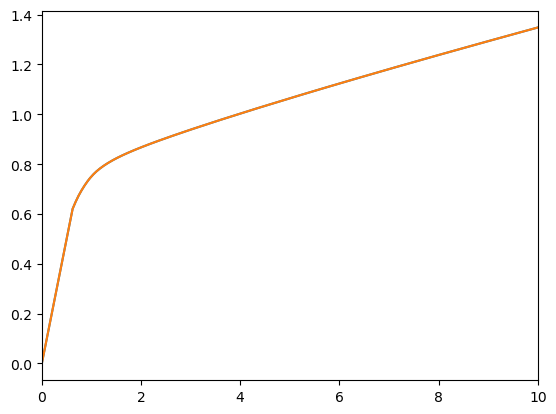

In [12]:
plot_funcs(
    [LifecycleExample.solution[0].cFunc, solution.cFunc],
    LifecycleExample.solution[0].mNrmMin,
    10,
)

Although, it's probably even clearer if we just subtract the function values from each other at some grid.

In [13]:
eval_grid = np.linspace(0, 20, 200)
LifecycleExample.solution[0].cFunc(eval_grid) - solution.cFunc(eval_grid)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])